In [1]:
import pyvista as pv
import numpy as np
import os, flopy
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, LinearTriInterpolator
from tqdm import tqdm

    
name = 'Model'
workspace = '../model'
mf_exe_name = '../exe/mf6'

sim = flopy.mf6.MFSimulation.load(sim_name=name, exe_name=mf_exe_name, sim_ws=workspace)

mfmodel = sim.get_model(model_name='model')

fname = os.path.join(workspace, name + '.hds')
hdobj = flopy.utils.HeadFile(fname, precision='double')
head = hdobj.get_data()
headRshp = head.reshape((head.shape[0],head.shape[2]))

flopy is installed in /home/gida2/.local/lib/python3.6/site-packages/flopy
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package npf...
    loading package ic...
    loading package rch...
    loading package evt...
    loading package drn...
    loading package oc...
  loading ims package model...


In [2]:
mTopCent = mfmodel.disv.top.get_data()
verticesXYArray = np.dstack((mfmodel.disv.vertices.array.xv,mfmodel.disv.vertices.array.yv))[0]
centroidXYArray = np.dstack((mfmodel.disv.cell2d.array.xc,mfmodel.disv.cell2d.array.yc))[0]

listOfCell2d = []
for index, cell in enumerate(mfmodel.disv.cell2d.array):
    vertexIndexList = [x for x in list(cell)[3:] if x is not None]
    listOfCell2d.append(vertexIndexList)

def triInterpolation(zValue, xPoints, yPoints):
    triObj = Triangulation(xPoints, yPoints)
    fz = LinearTriInterpolator(triObj, zValue)
    return fz

def interpVertices(zName, zValues, xyCentroid, xyVertices):
    interpVerticesList=[]
    layTri = triInterpolation(zValues, xyCentroid[:,0], xyCentroid[:,1])
    
    for index, vertice in tqdm(enumerate(xyVertices), desc="Working for vertices for %s"%zName):
        
        newZ = layTri(vertice[0],vertice[1])
        if newZ.mask:
            for index2, row2 in enumerate(listOfCell2d):
                if index in row2[1:]:
                    newZ = zValues[index2]
        interpVerticesList.append(newZ)
        
    interpVerticesArray = np.array(interpVerticesList)
    return interpVerticesArray

In [3]:
nlay = mfmodel.disv.nlay.array
nvert = mfmodel.disv.nvert.array
ncpl = mfmodel.disv.ncpl.array
modelCellZ = np.vstack((mfmodel.disv.top.array,mfmodel.disv.botm.array))
modelVertZ = np.zeros((nlay+1,mfmodel.disv.nvert.array))
#print(modelVertZ.shape)
for i in range(modelCellZ.shape[0]):
    modelVertZ[i] = interpVertices('Lay '+str(i),modelCellZ[i], centroidXYArray, verticesXYArray)

Working for vertices for Lay 0: 99154it [00:08, 12061.63it/s]
Working for vertices for Lay 1: 99154it [00:08, 11199.16it/s]
Working for vertices for Lay 2: 99154it [00:08, 11663.46it/s]
Working for vertices for Lay 3: 99154it [00:08, 11812.47it/s]
Working for vertices for Lay 4: 99154it [00:08, 12023.37it/s]
Working for vertices for Lay 5: 99154it [00:08, 11696.74it/s]
Working for vertices for Lay 6: 99154it [00:08, 11641.39it/s]


### for model geometry

In [ ]:
cellTubes = {}
for index, cell in tqdm(enumerate(listOfCell2d[:2]), desc="Creating the whole geometry"):
    
    filterCell2dArray = np.array([[cell[0]]+list(range(cell[0]))])
    #create polydata for lay
    layerTubes = {}
    
    for lay in range(nlay):
        baseXYZ = np.zeros([cell[0],3])
        #for index, row in enumerate(cell[1:]):
        #print(modelVertZ[lay].reshape([nvert,1]))
        baseXYZ = np.hstack((verticesXYArray,modelVertZ[lay].reshape([nvert,1])))
        #print(filterCell2dArray)
        #print(baseXYZ)
        cell2dArray = np.hstack(listOfCell2d)
        #print(listOfCell2d)
        #cellSurf = pv.PolyData(filterCell2dArray, baseXYZ[index])
        cellSurf = pv.PolyData(baseXYZ,cell2dArray)
        cellZ = modelCellZ[:,index]
        cellMesh = cellSurf.extrude([0, 0, cellZ[lay+1]-cellZ[lay]])
        layerTubes[str(lay)] = cellMesh  
    blocks = pv.MultiBlock(layerTubes)
    cellTubes[str(index)] = blocks.combine()
totalModelCells  = pv.MultiBlock(cellTubes)
totalModelMerged = totalModelCells.combine()
totalModelMerged.save('../vtk/modelGeometry.vtk')

In [44]:
baseGridXYZ = np.hstack((verticesXYArray,np.zeros([nvert,1])))
cell2dArray = np.hstack(listOfCell2d)
baseGrid = pv.PolyData(baseGridXYZ,cell2dArray)

layerTubes = {}
for lay in tqdm(range(nlay),desc=("Working geometries for model grid")):
    workingGrid = baseGrid.copy()
    workingVolume = workingGrid.extrude([0,0,1])
    for vert in range(nvert):
        workingVolume.points[vert][2] = modelVertZ[lay,vert]
        workingVolume.points[vert+nvert][2] = modelVertZ[lay+1,vert]
    layerTubes[str(lay)] = workingVolume
layerBlocks = pv.MultiBlock(layerTubes)
totalModelGrid = layerBlocks.combine()
totalModelGrid.save('../vtk/totalModelGrid.vtk')

print('Working on the outer model shell')
workingGrid = baseGrid.copy()
workingVolume = workingGrid.extrude([0,0,1])
for vert in range(nvert):
    workingVolume.points[vert][2] = modelVertZ[0,vert]
    workingVolume.points[vert+nvert][2] = modelVertZ[nlay,vert]
workingVolume.save('../vtk/modelOuterShell.vtk')

layerTubes = {}
for lay in tqdm(range(nlay),desc=("Working head cell for model grid")):
    workingGrid = baseGrid.copy()
    #assigning the cell heads
    cellHeads = head[0][0]
    cellHeads[cellHeads == -1.00000000e+30] = np.nan
    workingVolume = workingGrid.extrude([0,0,1])
    for vert in range(nvert):
        workingVolume.points[vert][2] = modelVertZ[lay,vert]
        workingVolume.points[vert+nvert][2] = modelVertZ[lay+1,vert]
    for cell in range(ncell):
        workingVolume.cell
    layerTubes[str(lay)] = workingVolume
layerBlocks = pv.MultiBlock(layerTubes)
totalModelGrid = layerBlocks.combine()
totalModelGrid.save('../vtk/totalModelGrid.vtk')


Working geometries for model grid: 100%|██████████| 6/6 [00:23<00:00,  3.84s/it]


Working on the outer model shell


In [59]:
cellHeads = head[0][0]
cellHeads[cellHeads == -1.00000000e+30] = np.nan
cellHeads

array([3614.26081605, 3614.3274543 ,           nan, ...,           nan,
                 nan,           nan])

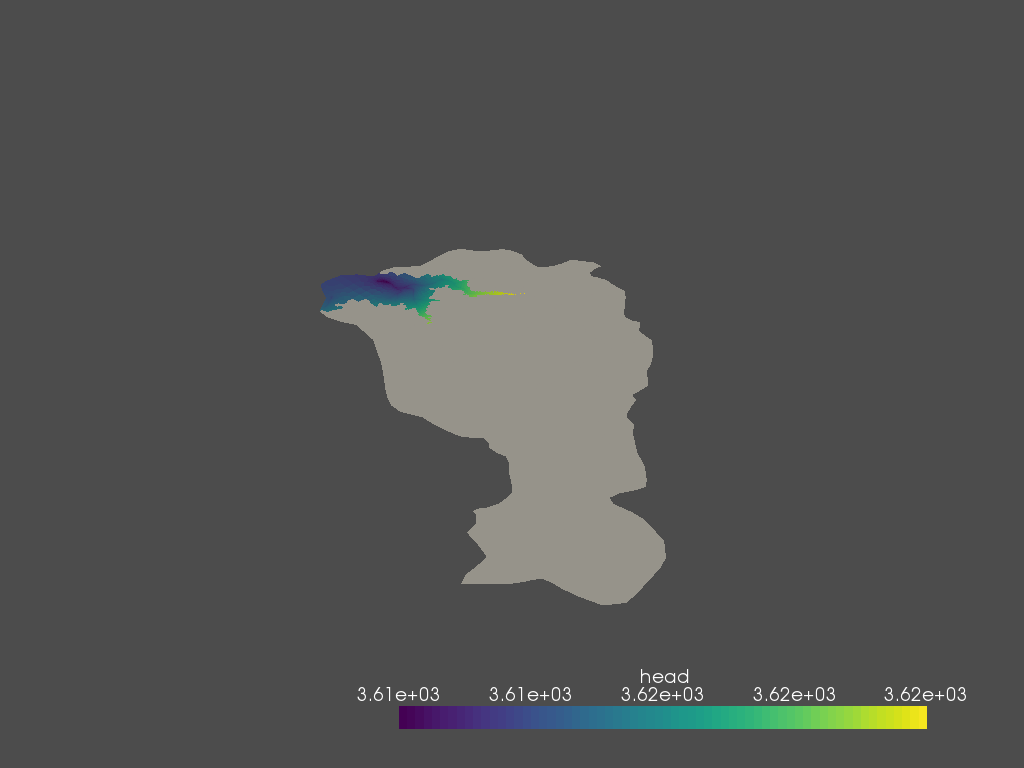

In [61]:
workingGrid.cell_arrays['head'] = cellHeads
workingGrid.plot()

### for cell heads

### for water table

### for drain boundary

In [ ]:

drnPkg = mfmodel.get_package('drn_0')
drainTubes = {}
for index, drnCell in tqdm(enumerate(drnPkg.stress_period_data.array[0])):
    cellNumber = drnCell[0][1]
    cellLay = drnCell[0][0]
    cellGrid = mfmodel.disv.cell2d.array[cellNumber]
    vertexIndexList = [x for x in list(cellGrid)[4:] if x is not None]
    filterVertexIndexList = [len(vertexIndexList)] + list(range(len(vertexIndexList)))
    filterVertexIndexArray = np.array(filterVertexIndexList)
    filterVertexArray = np.array([list(verticesXYArray[vertex]) + [modelCellZ[cellLay,cellNumber]] for vertex in vertexIndexList])
    cellSurf = pv.PolyData(filterVertexArray, filterVertexIndexArray)
    cellSurf.cell_arrays['elevation'] = drnCell[1]
    cellSurf.cell_arrays['cond'] = drnCell[2]
    cellZ = modelCellZ[:,cellNumber]
    cellMesh = cellSurf.extrude([0, 0, cellZ[cellLay +1]-cellZ[cellLay]])
    drainTubes[str(index)] = cellMesh 
totalDrainsCells = pv.MultiBlock(drainTubes)
totalDrainsMerged = totalDrainsCells.combine()
totalDrainsMerged.save('../vtk/modelDrains.vtk')

In [ ]:
import pyvista as pv
import numpy as np
import os, flopy
import matplotlib.pyplot as plt
name = 'Model'
workspace = '../model'
mf_exe_name = '../exe/mf6'

sim = flopy.mf6.MFSimulation.load(sim_name=name, exe_name=mf_exe_name, sim_ws=workspace)

mfmodel = sim.get_model(model_name='model')

fname = os.path.join(workspace, name + '.hds')
hdobj = flopy.utils.HeadFile(fname, precision='double')
head = hdobj.get_data()
headRshp = head.reshape((head.shape[0],head.shape[2]))

mtop = np.ones([mfmodel.disv.nvert.array ])*mfmodel.disv.top[0]
verticesXYArray = np.dstack((mfmodel.disv.vertices.array.xv,mfmodel.disv.vertices.array.yv))[0]

In [ ]:
modelz = np.vstack((mfmodel.disv.top.array,mfmodel.disv.botm.array))
nlay = mfmodel.disv.nlay.array

In [ ]:
cellSurf = pv.PolyData()

In [ ]:
mtop